# Проект "Интернет-магазин компьютерных игр"

Проект по анализу исторических данных о продажах игр. Данные получены из открытых источников, включают в себя продажи игр, оценки пользователей и экспертов, жанры и платформы ( информация за 2016 год может быть неполной). Цель проекта - выявить определяющие успешность игры закономерности. 

План проекта:
1. Подготовка данных
2. Исследовательский анализ данных
3. Портрет пользователя для каждого региона
4. Проверка гипотез:
       1) Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
       2) Средние пользовательские рейтинги жанров Action и Sports разные
5. Общий вывод

# 1. Первичный анализ данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import warnings

import scipy
from scipy import stats as st

warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('D:/Практикум-DS/Проекты для портфолио/games.csv')
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


__Вывод:__
Всего в датафрейме 16715 строк, в некоторых столбцах есть пропуски, часть числовых данных имеет тип 'object', названия столбцов нужно привести к стандартному виду - перевести в нижний регистр.

# 2. Подготовка датасета к дальнейшему анализу

## 2.1 Замена названий столбцов

In [3]:
data.columns = data.columns.str.lower()
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


## 2.2 Обработка пропусков

In [4]:
print(data.isnull().sum())

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64


Заполнить пропуски в столбце 'name' невозможно, имеет смысл их удалить, тем более пропуска всего два.
Строки с пропусками в столбце 'year_of_release' также можно удалить, так как заполнить их корректно невозможно, и их также немного.
Пропуски в столбцах 'critic_score' и 'user_score' корректно заполнить невозможно, а так как эти данные будут использоваться в дальнейшем исследовании, то их лучше оставить незаполненными.


### Удаление строк с пропусками в столбце 'name' и 'year_of_release'

In [5]:
data=data.dropna(subset=['name']).reset_index(drop=True)
data=data.dropna(subset=['year_of_release']).reset_index(drop=True)

data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating             6676
dtype: int64

### Заполнение пропусков в столбце 'rating'

In [6]:
# посмотрим на уникальные значения в столбце "рейтинг"
print(data['rating'].unique())
data['rating'].value_counts()

['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']


E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

Изучение рейтингов показало, что в этом столбце есть 4 редко встречающихся значения: 'AO','K-A', 'EC', 'RP', их можно просто удалить. Пропуски заполним значением 'N/A' - так они не будут мешать рассчетам, но и не исказят результаты исследования.

In [7]:
data['rating']=data['rating'].fillna('N/A')
data = data[data['rating'].isin (['AO','K-A', 'EC', 'RP']) == False ]

data['rating'].value_counts()

N/A     6676
E       3921
T       2905
M       1536
E10+    1393
Name: rating, dtype: int64

In [8]:
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8451
user_score         6605
rating                0
dtype: int64

### Анализ столбца 'user_score'

In [9]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В столбце 'user_score' преимущественно числовые значения от 0 до 10, есть пропуски, которые невозможно заполнить, не исказив результаты. Есть значение 'tbd', которое можно интерпретировать, как "пока не определено", то есть пользователь начал играть, но оценку поставить еще не готов. Для удобства исследования данных с использованием данного столбца лучше заменить 'tbd' на 'nan' - на результате это никак не скажется.

In [10]:
data['user_score']=data['user_score'].replace('tbd', np.NaN)
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

### Изучение столбца 'critic_score'

In [11]:
np.sort(data['critic_score'].unique())

array([13., 17., 19., 20., 21., 23., 24., 25., 26., 27., 28., 29., 30.,
       31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
       44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
       57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
       70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82.,
       83., 84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95.,
       96., 97., 98., nan])

В столбце 'critic_score' преимущественно числовые значения от 0 до 100, есть пропуски, которые невозможно заполнить, не исказив результаты.

__Причины пропусков:__ пропуски могли появится в данных за ранние периоды, так как тогда информация еще не собиралась, а восстановить ее позже в полном объеме не удалось, рейтинги тоже могли быть необязательными или проставлялись не для всех регионов. Пропуски в данных по оценкам пользователей и критиков скорее всего связаны с тем, что технической возможности оценки не было в тот момент. Часть данных могла быть утеряна в результате некорректной выгрузки информации (например название игры и жанр).

## 2.3 Изменение типов данных

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16431 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16431 non-null  object 
 1   platform         16431 non-null  object 
 2   year_of_release  16431 non-null  float64
 3   genre            16431 non-null  object 
 4   na_sales         16431 non-null  float64
 5   eu_sales         16431 non-null  float64
 6   jp_sales         16431 non-null  float64
 7   other_sales      16431 non-null  float64
 8   critic_score     7980 non-null   float64
 9   user_score       7457 non-null   object 
 10  rating           16431 non-null  object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Прежде всего имеет смысл изменить тип данных в столбце 'year_of_release' - в реальности он целочисленный, могут получаться некорретные значения при вычислениях, если оставить тип float, а также в столбце 'user_score' - для вычислений будет лучше, если будет тип float.

In [13]:
data=data.astype({'year_of_release':'int64'})
data=data.astype({'user_score':'float64'})
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16431 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16431 non-null  object 
 1   platform         16431 non-null  object 
 2   year_of_release  16431 non-null  int64  
 3   genre            16431 non-null  object 
 4   na_sales         16431 non-null  float64
 5   eu_sales         16431 non-null  float64
 6   jp_sales         16431 non-null  float64
 7   other_sales      16431 non-null  float64
 8   critic_score     7980 non-null   float64
 9   user_score       7457 non-null   float64
 10  rating           16431 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


## 2.4 Подсчет суммарных продаж по всем регионам

In [14]:
data['total_sales']=data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

# 3. Исследовательский анализ данных

## 3.1 Динамика выпуска игр в разные годы

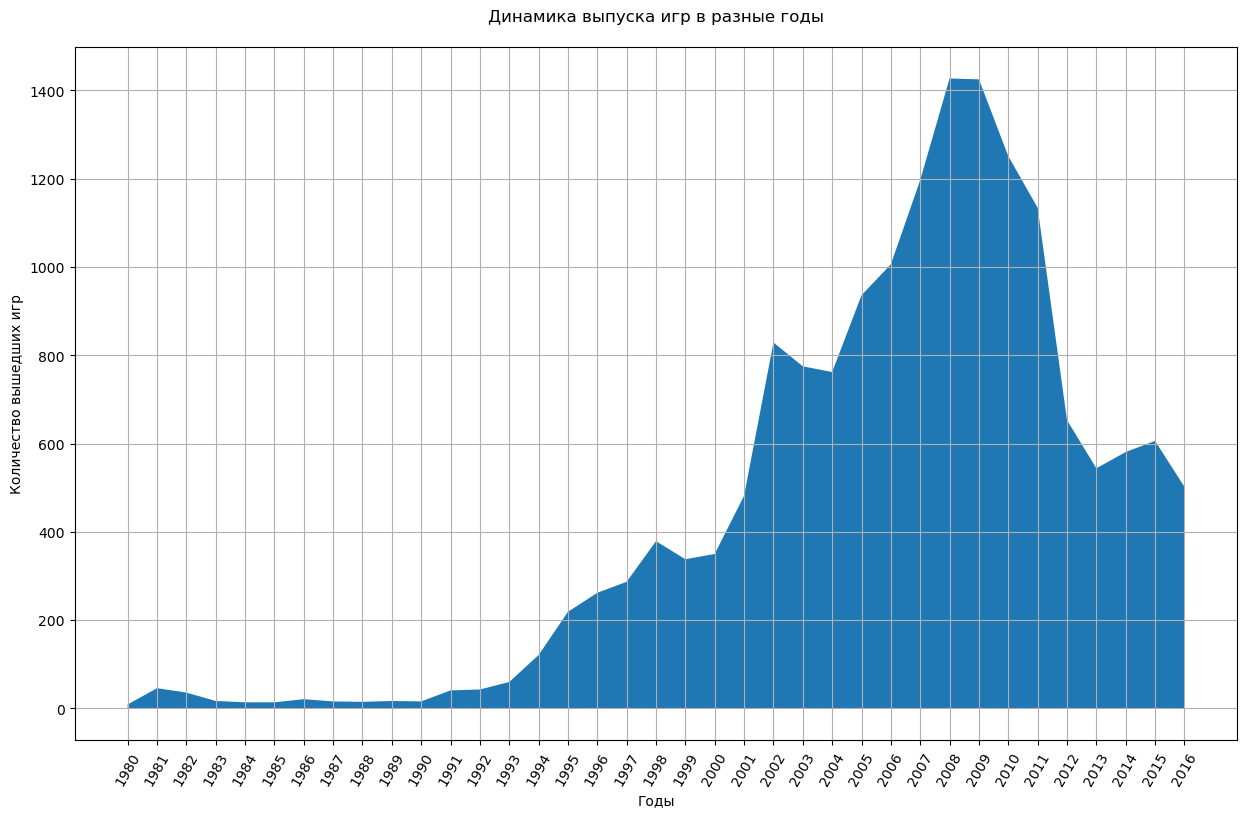

In [15]:
data_year=data.groupby('year_of_release').agg(games=('name', 'count')).reset_index()
plt.figure(figsize=(15, 9));
plt.grid();
plt.fill_between(data_year['year_of_release'], data_year['games']);
plt.xticks(np.arange(data_year['year_of_release'].min(), data_year['year_of_release'].max()+1, 1));
plt.xticks(rotation = 60);
plt.xlabel("Годы");
plt.ylabel("Количество вышедших игр");
plt.title('Динамика выпуска игр в разные годы\n');

plt.show()

__Вывод:__ В период с 1980 по 2001 годы выходило менее 500 игр в год, что недостаточно для того, чтобы делать какие-то выводы об этих периодах. Поэтому можно для дальнейшей оценки использовать данные с 2002 по 2016 годы.

## 3.2 Динамика объемов продаж по всем платформам

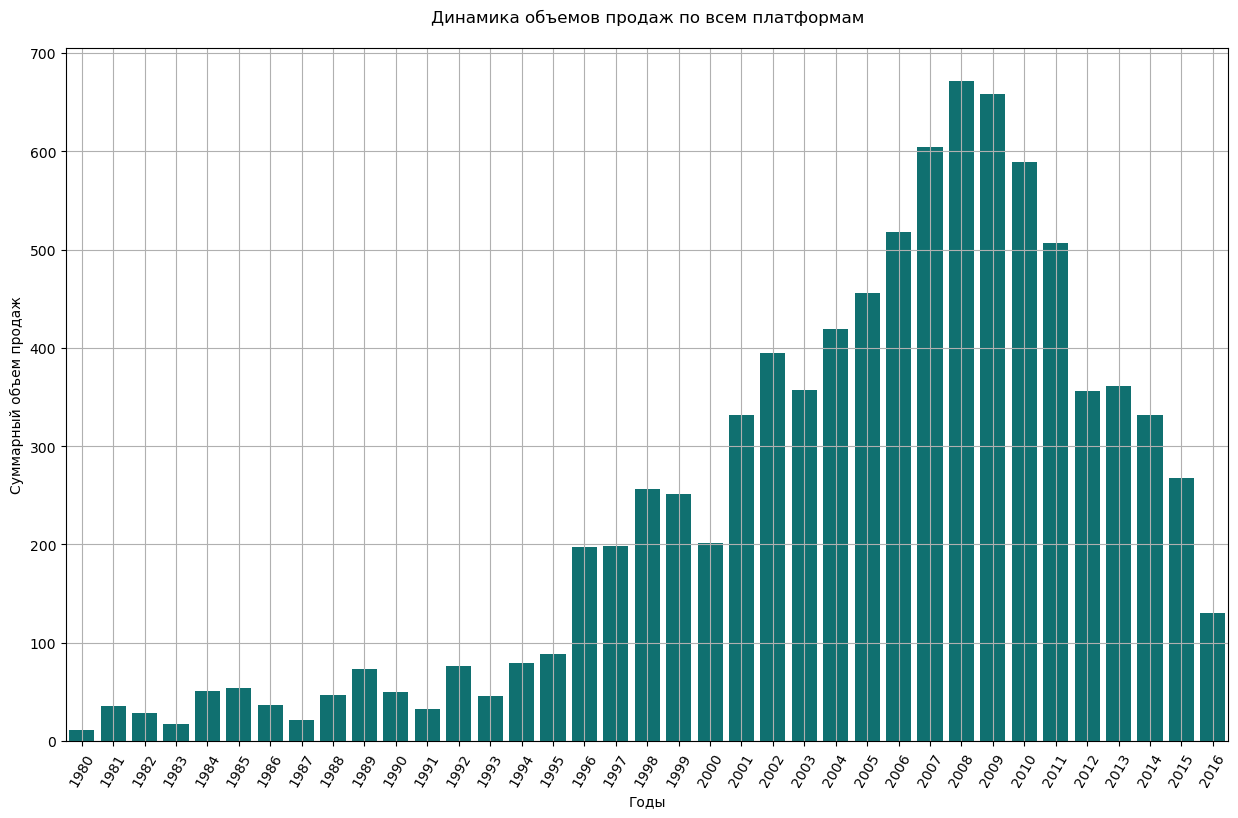

In [16]:
data_sales=data.groupby('year_of_release').agg(sales=('total_sales', 'sum')).reset_index()

plt.figure(figsize=(15, 9));
plt.title('Динамика объемов продаж по всем платформам\n');
plt.xticks(np.arange(data_sales['year_of_release'].min(), data_sales['year_of_release'].max()+1, 1));
sns.barplot(data=data_sales, x='year_of_release', y='sales', color='teal');
plt.xticks(rotation = 60);
plt.xlabel("Годы");
plt.ylabel("Суммарный объем продаж");
plt.grid(True)
plt.show();

По графику видно, что рост популярности игр пришелся на середину 90х, достиг пика в 2008-2009 годах, далее пошел спад.

Посмотрим, на платформы с наибольшим объемом продаж.

## 3.3 Распределение продаж по годам по наиболее успешным платформам

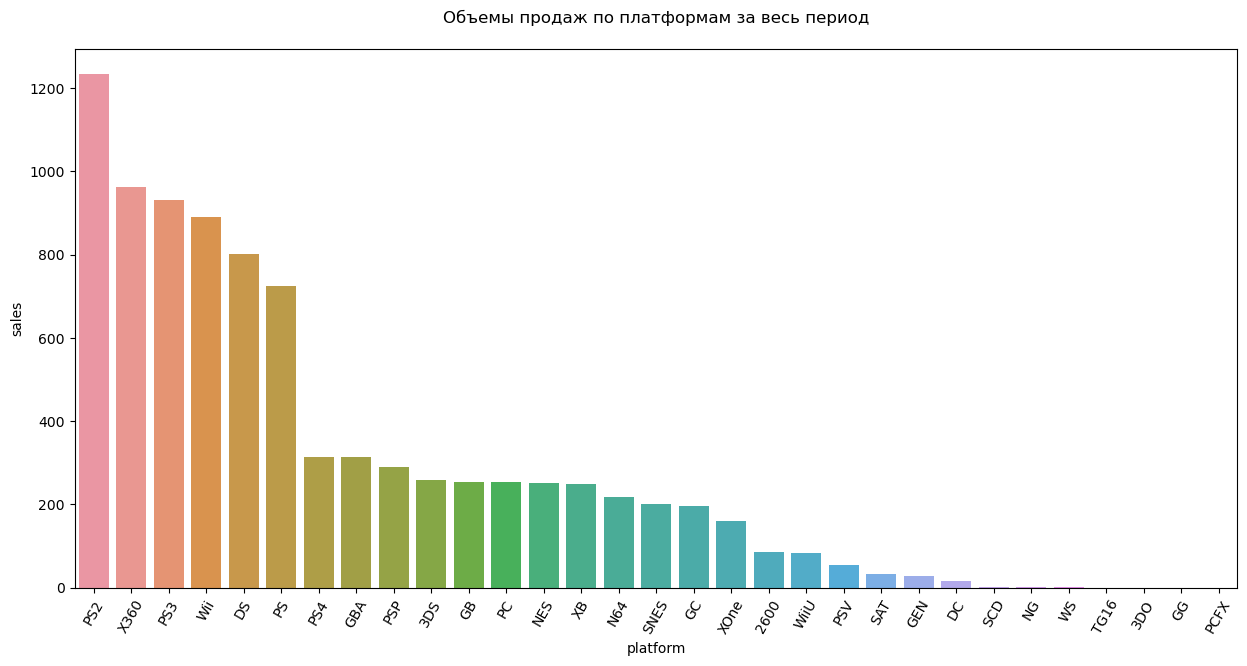

  platform    sales
0      PS2  1233.32
1     X360   961.24
2      PS3   931.34
3      Wii   890.52
4       DS   802.13
5       PS   725.67


In [17]:
data_platform_top=data.groupby('platform').agg(sales=('total_sales', 'sum')).\
                    sort_values(by='sales',ascending=False).reset_index()
plt.figure(figsize=(15, 7));
plt.xticks(rotation = 60);
sns.barplot(data=data_platform_top, x='platform', y='sales')
plt.title('Объемы продаж по платформам за весь период\n')
plt.show();
data_platform_top=data_platform_top[:6]
print(data_platform_top)

Для дальнейшего анализа отберем 6 платформ с наибольшим объемом продаж: PS2, X360, PS3, Wii, DS и PS.
Построим по ним графики динамик продаж по годам.

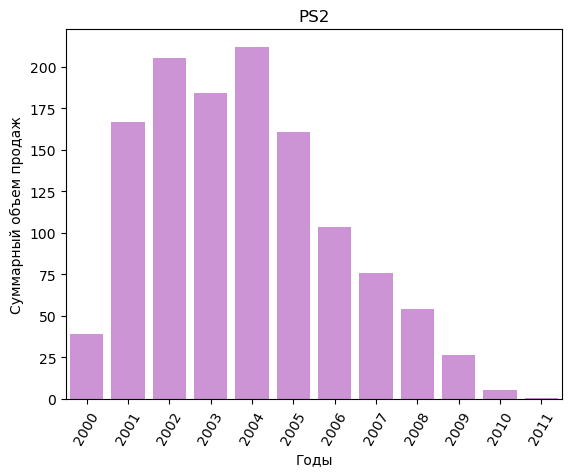

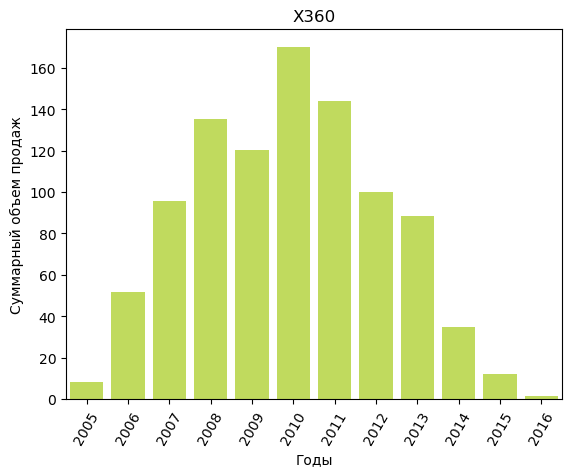

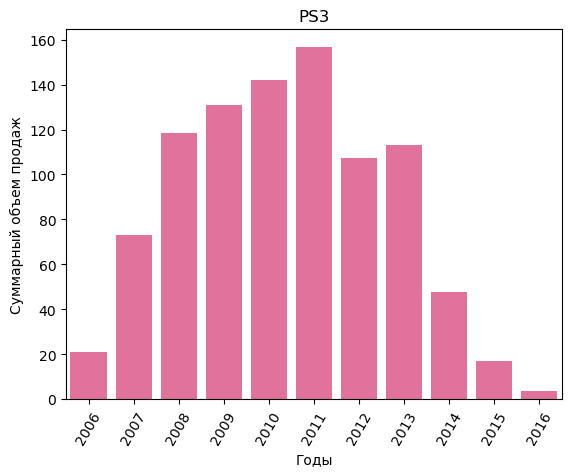

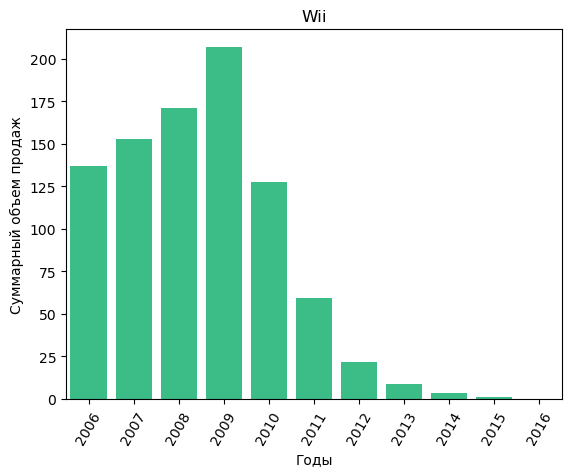

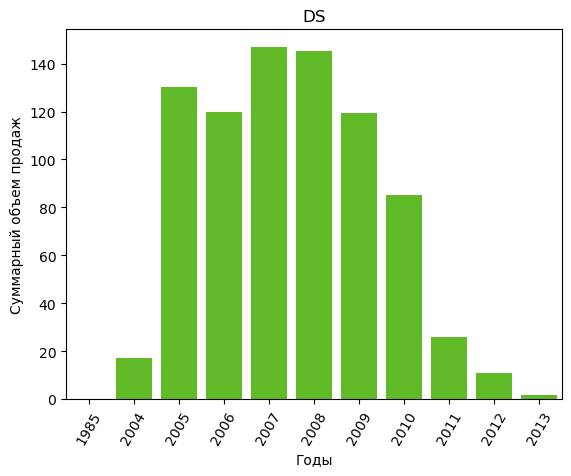

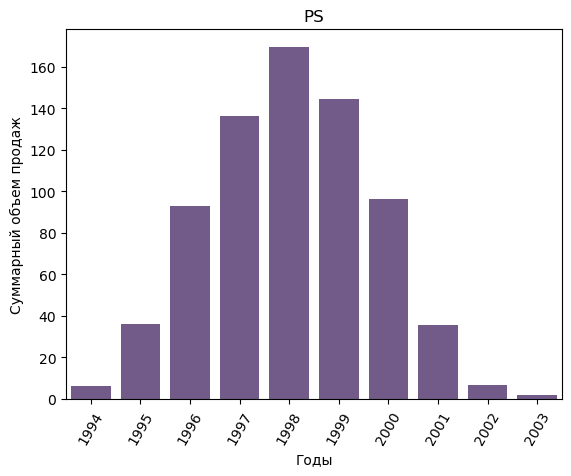

In [18]:
data_platform=data.groupby(['platform','year_of_release']).agg(sales=('total_sales', 'sum')).reset_index()

for platform in data_platform_top['platform'].unique():
    data_plat=data_platform[data_platform['platform'] == platform].drop('platform', axis=1)
    clr = '#'+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
    sns.barplot(data=data_plat, x='year_of_release', y='sales',color=clr)
    plt.title(platform)
    plt.xticks(rotation = 60);
    plt.xlabel("Годы");
    plt.ylabel("Суммарный объем продаж");
    plt.show();

По динамикам продаж для самых прибыльных платформ за весь наблюдаемый период видно, что новые платформы "живут" около 10 лет, а затем сменяются более современными.

__Вывод:__ Задача стоит провести исследование с целью прогноза на 2017 год, поэтому имеет смысл взять данные за последние 5 лет, чтобы не упустить платформу, которая сейчас достигла пика, но и не брать в расчет платформы, популярность которых уже сходит на нет.

## 3.4 Выбор нескольких потенциально прибыльных платформ

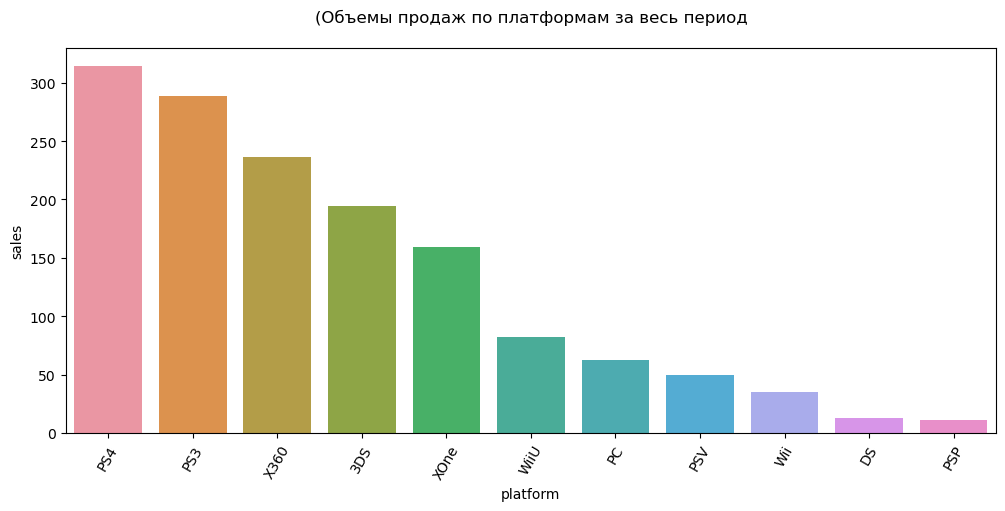

In [19]:
#оставляем данныетолько за 2012-2016 годы
data_new=data.query('year_of_release > 2011')

data_new_sales=data_new.groupby('platform').agg(sales=('total_sales', 'sum')).\
                sort_values(by='sales',ascending=False).reset_index()

plt.figure(figsize=(12, 5));
plt.xticks(rotation = 60);
sns.barplot(data=data_new_sales, x='platform',y='sales')
plt.title('(Объемы продаж по платформам за весь период\n')
plt.show();

Наиболее перспективными на первый взгляд кажутся первые 5 платформ: PS4, PS3, X360, 3DS, Xone. Посмотрим подробнее на динамику продаж по всем платформам, так как некоторые из них могли появиться совсем недавно и еще только набирают популярность.

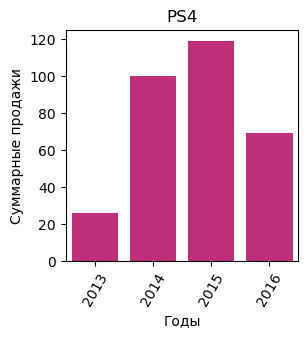

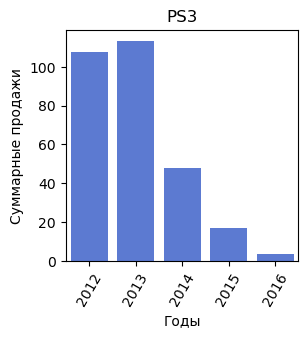

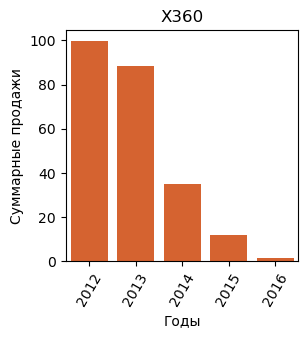

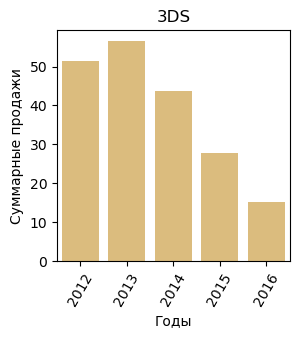

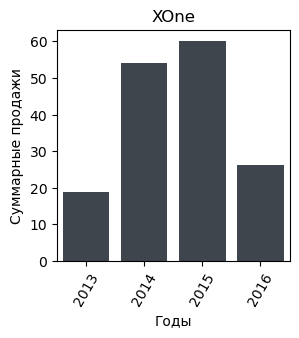

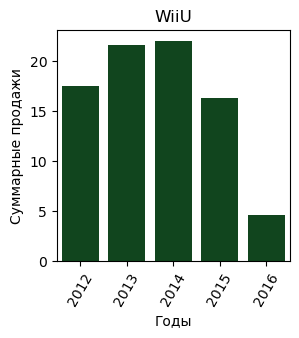

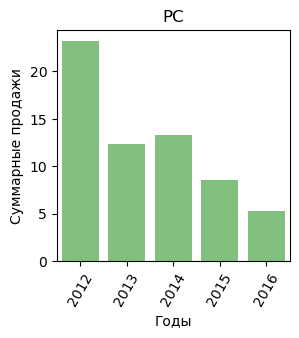

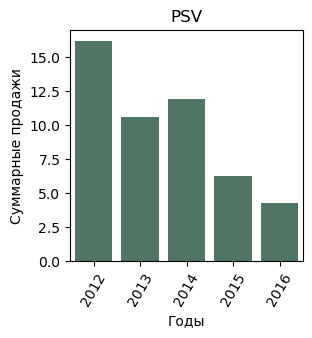

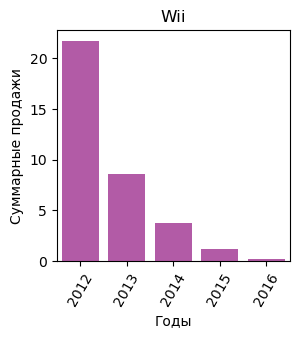

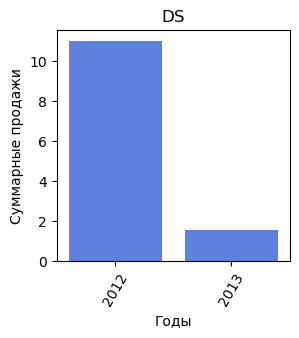

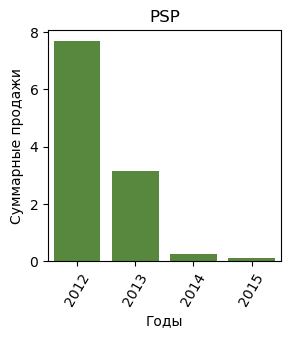

In [20]:
data_new_platform=data_new.groupby(['platform','year_of_release']).agg(sales=('total_sales', 'sum')).reset_index()
data_new_top=data_new_sales[:11]

for platform in data_new_top['platform'].unique():
    plt.figure(figsize=(3, 3));
    data_plat=data_new_platform[data_new_platform['platform'] == platform].drop('platform', axis=1)
    clr = '#'+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
    sns.barplot(data=data_plat, x='year_of_release', y='sales',color=clr);
    plt.title(platform)
    plt.xticks(rotation = 60);
    plt.xlabel("Годы");
    plt.ylabel("Суммарные продажи");
    plt.show();

Очевидно, сразу можно отбросить PSP и DS - продаж за последние 2 года было очень мало или не было совсем. Явную тенденцию к снижению уровня продаж можно увидеть по платформам: Wii, X360, PS3.
Явная тенденция к росту продаж, с учетом неполных данных за 2016 год видна по платформам: PS4 и XOne, по остальным платформам больше похоже, что популярность платформы уже перевалила за пик.

## 3.5 "Ящик с усами" по глобальным продажам игр в разбивке по платформам

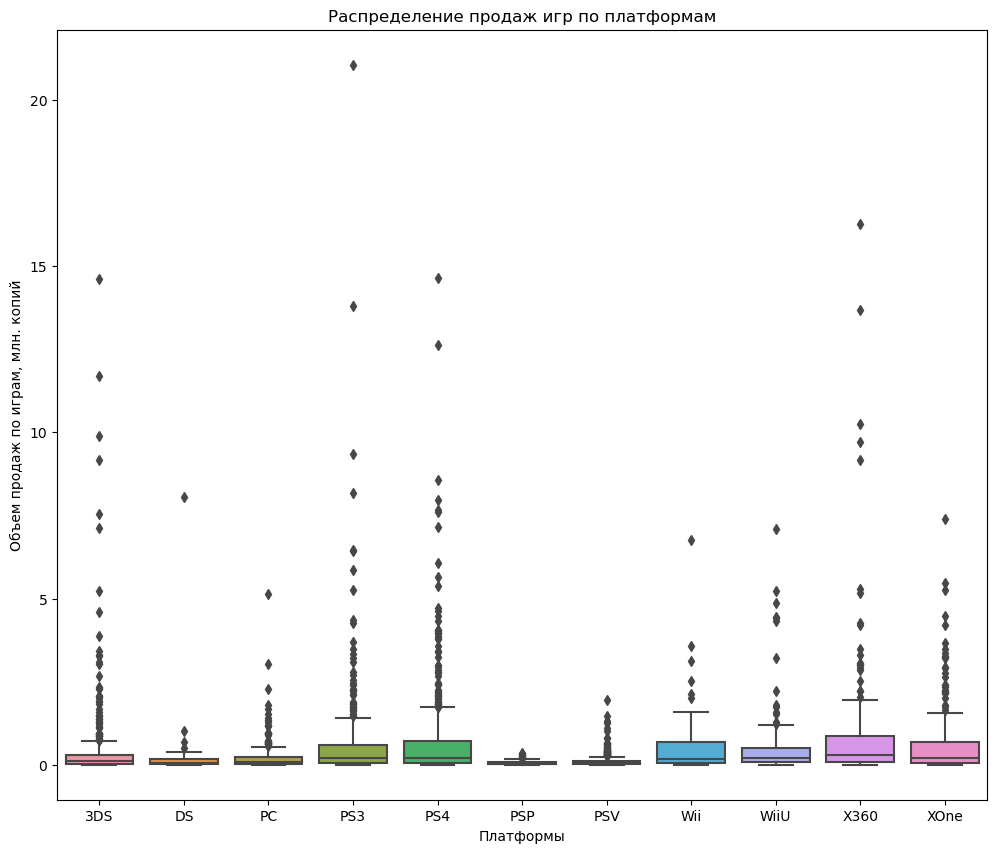

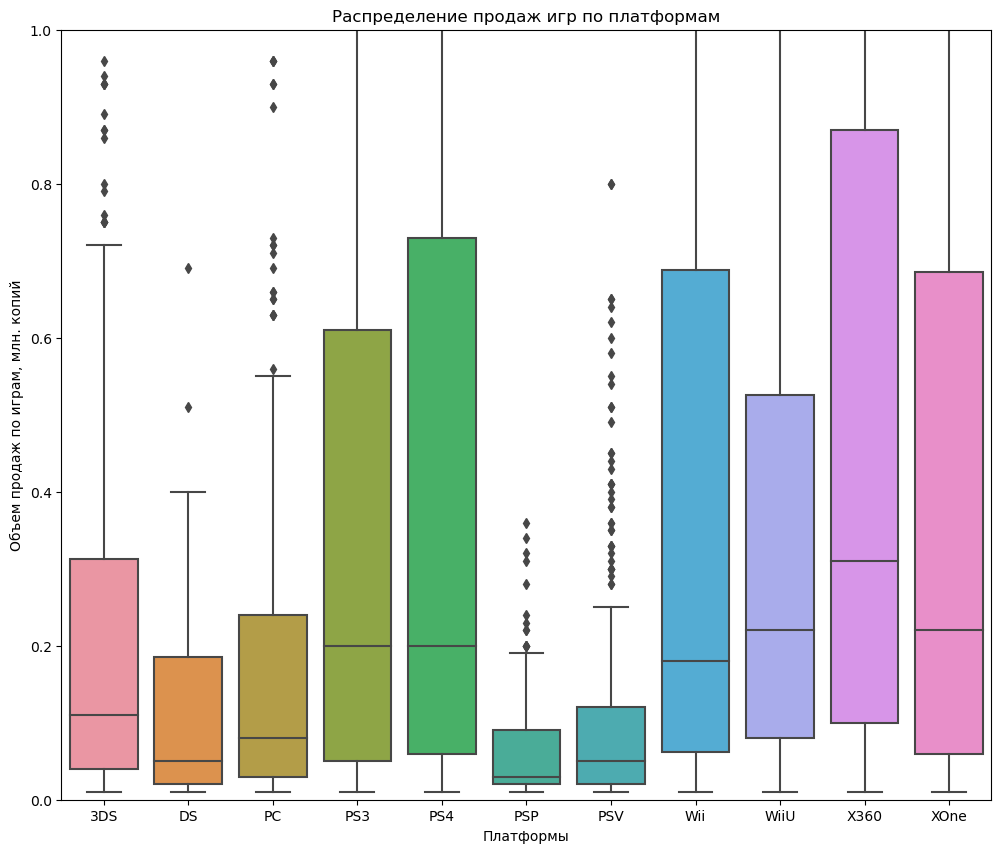

In [21]:
data_new.head()
data_platform_sales=data_new.groupby(['platform','name']).agg(sales=('total_sales','sum')).reset_index()
plt.figure(figsize=(12, 10));
sns.boxplot( x=data_platform_sales["platform"], y=data_platform_sales["sales"] )
plt.xlabel("Платформы");
plt.ylabel("Объем продаж по играм, млн. копий");
plt.title('Распределение продаж игр по платформам')
plt.show();

plt.figure(figsize=(12, 10));
ax=sns.boxplot( x=data_platform_sales["platform"], y=data_platform_sales["sales"] )
ax.set(ylim=(0,1))
plt.xlabel("Платформы");
plt.ylabel("Объем продаж по играм, млн. копий");
plt.title('Распределение продаж игр по платформам')
plt.show();

Вывод: почти по всем платформам у распределений длинный хвост, выходящий далеко за пределы усов - значит есть редкие очень прибыльные игры, основная же масса игр приносит относительно невысокую прибыль. Исключение составляет, пожалуй, только PSP и DS - тут все распределение очень "прижато" к нулю - относительно других платформ объемы продаж небольшие и "хиты" приносят относительно невысокую прибыль, что соответствует выводу из предыдущего исследования - эти платформы уже в конце своего жизненного цикла.

Судя по нижней части графиков наиболее прибыльной за весь рассматриваемый период является платформа X360 (популярность которой согласно гистограмме продаж по годам уже сходит на нет), так же выглядят перспективно PS4, XOne, относительно высокий уровень продаж (и по медиане, и по высоте самого "ящика") у платформ PS3, Wii и WiiU. Остальные платформы и по медианному уровню продаж, и по уровню 75% квантиля заметно отстают.

## 3.6 Влияние на продажи платформы One отзывов пользователей и критиков. Диаграмма рассеяния и корреляция между отзывами и продажами

Корреляция глобальных продаж и отзывов критиков: 0.42


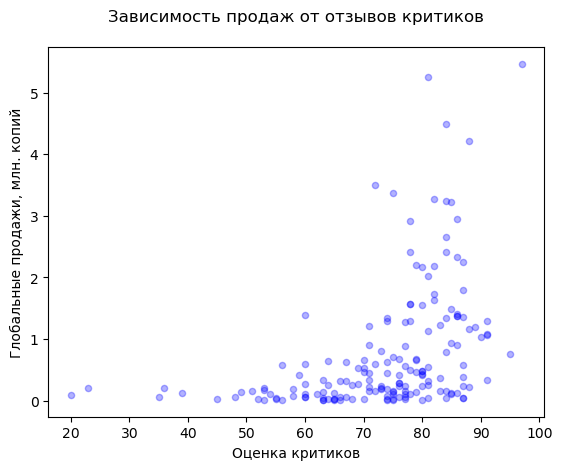


Корреляция глобальных продаж и отзывов пользователей: -0.07


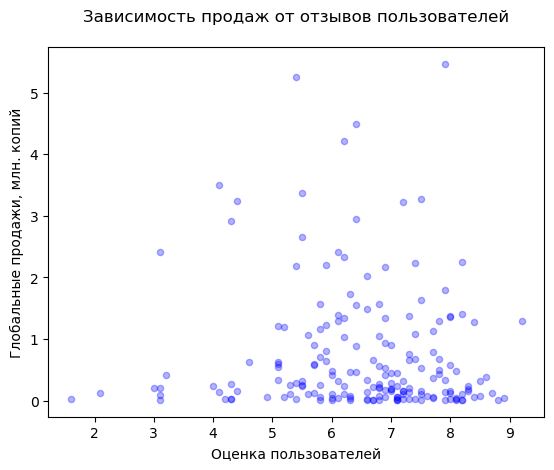

In [22]:
# делаем срез по платформе XOne
data_one=data_new.query('platform == "XOne"')

# смотрим взаимосвязть продаж и оценок критиков
print('Корреляция глобальных продаж и отзывов критиков:', '{:.2f}'.format(data_one['total_sales'].\
                                                                          corr(data_one['critic_score'])))
data_one.plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.3, c = 'b', s = 20);
plt.xlabel('Оценка критиков'); 
plt.ylabel('Глобальные продажи, млн. копий');
plt.title('Зависимость продаж от отзывов критиков\n');
plt.show();

# смотрим взаимосвязть продаж и оценок пользователей
print('\nКорреляция глобальных продаж и отзывов пользователей:', '{:.2f}'.format(data_one['total_sales'].\
                                                                          corr(data_one['user_score'])))
data_one.plot(x='user_score', y='total_sales', kind='scatter', alpha=0.3, c = 'b', s = 20);
plt.xlabel('Оценка пользователей');
plt.ylabel('Глобальные продажи, млн. копий');
plt.title('Зависимость продаж от отзывов пользователей\n');

__Вывод:__ не выявлено связи между глобальными продажами игр для платформы XOne и оценками пользователей, оценки критиков влияют на глобальные продажи в бОльшей степени, но и эту связь нельзя назвать сильной и однозначной.
В сумме оценка по диаграммам boxplot по всем платформам и более подробная оценка продаж платформы Xone позволяют сделать выводы, что высокие продажи супер-популярных игр редки для любой платформы и судя по всему на это вляет множество факторов помимо оценок пользователей и критиков как таковых.

Посмотрим, как обстоят дела с остальными платформами, посчитаем корреляцию между оценками критиков/пользователей и суммарными продажами по всем платформам. Также посмотрим на общее количество оценок по всем платформам.

In [23]:
data_platform_user=data_new.groupby('platform')['user_score'].count()
data_platform_critic=data_new.groupby('platform')['critic_score'].count()
data_platform=data_new.groupby('platform')[['critic_score', 'user_score', 'total_sales']].corr()

data_platform = data_platform.rename_axis(("platform", "corr_type"))
data_platform=data_platform.query('corr_type != "critic_score" & corr_type != "user_score"')
data_platform=data_platform.drop(['total_sales'],axis=1)
data_platform=data_platform.droplevel('corr_type')
data_platform=data_platform.rename(columns={'critic_score':'critic_corr', 'user_score':'user_corr'})

data_platform=data_platform.merge(data_platform_critic, on='platform',how='left')
data_platform=data_platform.merge(data_platform_user, on='platform',how='left')
data_platform=data_platform.rename(columns={'critic_score':'critic_count', 'user_score':'user_count'})

display(data_platform.style.format({'critic_corr':'{:.2f}','user_corr':'{:.2f}'}))

,critic_corr,user_corr,critic_count,user_count
platform,,,,
3DS,0.32,0.20,104,114
DS,nan,0.88,1,3
PC,0.24,-0.12,198,206
PS3,0.33,-0.01,214,283
PS4,0.41,-0.03,252,257
PSP,nan,-0.80,1,4
PSV,0.09,-0.00,107,130
Wii,-0.42,0.30,5,17
WiiU,0.35,0.40,90,100


Для всех платформ характерна невысокая корреляция глобальных продаж с оценками критиков и пользователей, исключение - платформа DS: корреляция между продажами и оценкой пользователей 0.88 и платформа PSP: корреляция между продажами и оценкой пользователей 0.8, но по этим платформам крайне мало оценок, так что расчет корреляции нельзя считать корретным.

## 3.7 Общее распределение игр по жанрам. Самые прибыльные жанры. Жанры с высокими и низкими продажами.

In [24]:
func_list=['count','sum','max']
title_list=['Распределение игр по жанрам\n',\
            'Суммарные объемы продаж по жанрам\n',\
            'Максимальные продажи по жанрам\n']
y_title=['Количество игр', 'Глобальные продажи, млн. копий', 'Глобальные продажи, млн. копий]
color_list=['lightsteelblue','thistle','lightcoral']
for i in range(3):
    data_genre=data_new.groupby('genre')['total_sales'].agg(func_list[i]).reset_index().sort_values('total_sales', \
                                                                                                    ascending=False)
    plt.figure(figsize=(12, 5));
    sns.barplot(x=data_genre['genre'], y=data_genre['total_sales'], color=color_list[i])
    plt.xlabel('Genres (Жанры)');
    plt.ylabel(y_title[i]);
    plt.title(title_list[i]);
    plt.xticks(rotation = 60);
    plt.show();

data_genre=data_new.groupby('genre')['total_sales'].median().reset_index().sort_values('total_sales', ascending=False)
plt.figure(figsize=(12, 5));
ax=sns.boxplot(x=data_new['genre'], y=data_new['total_sales'], color='darkseagreen')
ax.set(ylim=(0,1.5))
plt.xlabel('Жанры');
plt.ylabel('Глобальные продажи, млн. копий');
plt.title('Распределение объемов продаж по жанрам\n');
plt.xticks(rotation = 60);
plt.show();

SyntaxError: EOL while scanning string literal (1851435506.py, line 5)

__Вывод:__ Среди всех жанров безусловное лидерство по количеству выпускаемых игр занимает Action - более 1000 игр за период с 2012 по 2016 год, в жарнрах Role-Playing, Adventure, Sports, Shooter и Misc за рассматриваемый период вышло от 200 до 400 игр приблизительно, в остальных жанрах - менее 100 игр.

Естесственно жанр Action лидирует по суммарным объемам продаж, но если посмотреть средние (медианные) значения, то лидеры будут совсем другие: с большим отрывом опережая другие жанры лидирует Shooter (более 400 тыс. копий), далее идут Sports и Platform ( от 200 до 250 тыс. копий), самые низкие показатели у жанров Puzzle и Adventure.

# 4. Портрет пользователя каждого региона

Задача - определить для каждого региона (North America, Europe, Japan): cамые популярные платформы (топ-5), самые популярные жанры (топ-5), выяснить, влияет ли рейтинг ESRB на продажи в отдельном регионе.

## 4.1 Топ-5 популярных платформ

In [ ]:
fig, ax= plt.subplots(1,3, figsize =(20, 7));
plt.suptitle('Топ-5 платформ\n', y=1.1, fontsize=20)
subtitle_list=['Северная Америка\n', 'Япония\n', 'Европа\n']
col_region_list=['na_sales', 'jp_sales', 'eu_sales']

for i in range(3):
    data_temp=data_new.groupby('platform')[col_region_list[i]].sum().reset_index().\
                                sort_values(col_region_list[i], ascending=False).reset_index(drop=True)
    data_temp=data_temp.append({'platform':'other',col_region_list[i]: sum(data_temp.loc[5:10,col_region_list[i]])}, \
                           ignore_index=True).drop(index=[5,6,7,8,9,10])
    colors = ("teal", "mediumaquamarine","palegreen","yellowgreen","mediumseagreen","forestgreen")
    ax[i].pie(data_temp[col_region_list[i]], labels=data_temp['platform'],autopct='%1.1f%%', colors=colors, startangle=60);
    ax[i].axis('equal');
    ax[i].set_title(subtitle_list[i], fontsize=16);

plt.show();


Для Северной Америки, Японии и Европы топ-5 платформ отличаются, причем если для Америки и Европы тройка наиболее популярных одна и та же, а отличаются только доли (X360, PS4,PS3), то для Японии характерны другие платформы, X360 и Xone вообще не попадают в топ-5, зато 3DS по объемам приближается к половине всех продаж.

## 4.2 Топ-5 популярных жанров

In [ ]:
fig, ax= plt.subplots(1,3, figsize =(20, 7));
plt.suptitle('Топ-5 жанров\n', y=1.1, fontsize=20)

subtitle_list=['Северная Америка\n', 'Япония\n', 'Европа\n']
col_region_list=['na_sales', 'jp_sales', 'eu_sales']

for i in range(3):
    data_temp=data_new.groupby('genre')[col_region_list[i]].sum().reset_index().\
                                sort_values(col_region_list[i], ascending=False).reset_index(drop=True)
    data_temp=data_temp.append({'genre':'other',col_region_list[i]: sum(data_temp.loc[5:10,col_region_list[i]])}, \
                           ignore_index=True).drop(index=[5,6,7,8,9,10,11])
    colors = ("teal", "mediumaquamarine","palegreen","yellowgreen","mediumseagreen","forestgreen")
    ax[i].pie(data_temp[col_region_list[i]], labels=data_temp['genre'],autopct='%1.1f%%', colors=colors, startangle=60);
    ax[i].axis('equal');
    ax[i].set_title(subtitle_list[i], fontsize=16);

plt.show();


В топ-5 жанров похожая на топ-5 платформ ситуация: Северная Америка и Европа очень близки и по самим жанрам и по долям, а вот Япония пересекается в топ-3 только по жанру Action - он примерно одинаково популярен во всех трех регионах. В целом Японские потребители демонстрируют бОльшую однородность - два наиболее популярных жанра: Role-Playing и Action занимаются суммарно более 62% рынка, остальные жанры - менее 10% каждый. В Северной Америке и Европе тоже есть безусловные лидеры по жанрам (Action, Shooter и Sports), но доли жанров, не входящих в топ3 побольше.

## 4.3 Влияние рейтинга ESRB на продажи в разных регионах

In [ ]:
fig, ax= plt.subplots(1,3, figsize =(20, 7));
plt.suptitle('Влияние рейтинга ESRB на продажи в разных регионах', \
             y=1.1, fontsize=20)
title_list=['Северная Америка\n', 'Япония\n', 'Европа\n']
column_list=['na_sales', 'jp_sales', 'eu_sales']
data_esrb=data_new.groupby('rating')['na_sales','jp_sales','eu_sales'].sum().reset_index()

for i in range (3):
    sns.barplot(data=data_esrb,x='rating',y=column_list[i],ax=ax[i])
    ax[i].set_xlabel('Рейтинг ESRB');
    ax[i].set_ylabel('Объем продаж, млн. копий');
    ax[i].set_title(title_list[i], fontsize=16); 
plt.show();

__Вывод:__ большая часть продаж в Северной Америке и Европе приходится на игры с рейтингом "M" и "E"- только для взрослых старше 17 лет и для пользователей от 6 лет и старше, что по всей видимости соответствует "взрослым" и "детским" играм, по всей видимсти рейтинги "E10+" и "T" и используются реже, т.к. бОльшинство игр можно отнести к одной из первых двух возрастных категорий.
В Японии по всей видимости рейтинги ESRB  активно не используются (изначально ESRB ориентировалась на продукты для североамериканского рынка), поэтому и влияние на продажи сложно оценить.

# 5. Проверка гипотез

## 5.1 Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

__Нулевая гипотеза H0__: средний пользовательский рейтинг платформы Xbox One равен среднему пользовательскому рейтингу платформы PC.

__Альтернативная гипотеза H1__: средний пользовательский рейтинг платформы Xbox One не равен среднему пользовательскому рейтингу платформы PC.

Зададим пороговое значение __alpha=0.05__.

In [ ]:
data_xone=data_new.query('platform == "XOne"')['user_score'].dropna()
data_pc=data_new.query('platform == "PC"')['user_score'].dropna()

print("\nРазмер выборки по Xbox One:", len(data_xone))
print("Размер выборки по PC:", len(data_pc), "\n\n")

alpha = .05 # критический уровень статистической значимости

results =scipy.stats.ttest_ind(data_xone, data_pc, equal_var=False)

print('p-value (p-значение):', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу и принимаем альтернативную\n")
else:
    print("Принимаем нулевую гипотезу\n") 

Для проверки гипотезы использовался t-тест для проверки равенства средних двух генеральных совокупностей. Размеры выборок из генеральных совокупностей не равны, поэтому equal_var=False.

Значение p-value больше критического уровня в 5%, поэтому нельзя отвергнуть нулевую гипотезу, т.е. средние пользовательские оценки для платформ Xbox One и PC равны с вероятностью 95%.


## 5.2 Средние пользовательские рейтинги жанров Action  и Sports разные

__Нулевая гипотеза H0__: средний пользовательский рейтинг жанра Action равен среднему пользовательскому рейтингу жанра Sports.

__Альтернативная гипотеза H1__: средний пользовательский рейтинг жанра Action не равен среднему пользовательскому рейтингу жанра Sports.

Зададим пороговое значение __alpha=0.05__.

In [ ]:
data_action=data_new.query('genre == "Action"')['user_score'].dropna()
data_sports=data_new.query('genre == "Sports"')['user_score'].dropna()

print("\nРазмер выборки по жанру Action:", len(data_action))
print("Размер выборки по жанру Sports:", len(data_sports), "\n\n")

alpha = .05 # критический уровень статистической значимости

results =scipy.stats.ttest_ind(data_action, data_sports, equal_var=False)

print('p-value (p-значение):', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу и принимаем альтернативную\n")
else:
    print("Принимаем нулевую гипотезу\n") 

Для проверки гипотезы использовался t-тест для проверки равенства средних двух генеральных совокупностей. Размеры выборок из генеральных совокупностей не равны, поэтому equal_var=False.

Значение p-value меньше критического уровня в 5%, поэтому можно отвергнуть нулевую гипотезу, т.е. средние пользовательские оценки для жанров Action и Sports не равны с вероятностью 95%.




# 6.0 Общий вывод

1.  Анализ выпущенных за рассматриваемый период игр показал, что в 80ые и начале 90ых рынок игр только начал развиваться, резкий рост количества выпускаемых игр пришелся на середину 90х и продолжался до 2008-2009 годов, когда и достиг своего пика, с тех пор и до конца наблюдаемого периода наблюдается снижение.
2. Динамика объемов проданных копий по всем платформам и всем регионам в целом повторяет динамику выпуска игр: чем больше игр - тем больше их покупают.
3. Поверхностный анализ распределения объемов продаж по платформам за весь период выявил несколько лидеров, но при более подробном рассмотрении стало ясно, что часть этих платформ уже давно не востребованы, и их период сверхприбылей был 5-10 лет назад, тем не менее из-за общего спада на рынке игр они все еще лидируют по суммарным продажам за весь наблюдаемый период. Анализ топ-6 самых прибыльных платформ показал, что среднее "время жизни" платформы около 10 лет, поэтому для дальнейшего выбора перспективных платформ решено было оставить данные за последние 5 лет, чтобы не учитывать те платформы, по которым продажи уже почти сошли на нет.
4. Дальшейший анализ платформ актуальных с 2012 по 2016 годы позволил выявить 2 наиболее перспективные платформы : PS4 и XBox One.
5. Анализ распределения глобальных продаж с разбивкой по платформам показал, что для большинства платформ свойственны редкие супер-популярные игры, основная же масса приносит относительно немного покупок. Исключение - платформы, жизненный цикл которых уже завершается - там единичных сверхприбыльных игр уже нет. Также анализ распределния продаж по платформам подтвердил выводы предыдущего пункта - наиболее перспективными платформами являются PS4 и Xbox One.
6. Попытка выявить взаимосвязь между глобальными продажами и оценками критиков/пользователей не увенчалась успехом, скорее всего эта связь носит непростой характер, и в целом на продажи существенно влияют еще и другие факторы (например, выход фильма по игре провоцирует интерес к ней, наличие предыдущих популярных версий игры тоже наверняка повышает шансы на высокие продажи).
7. Выпуск игр в различных жанрах распределен неравномерно - c большим отрывом лидирует жанр Action, любопытно что при этом это не самый прибыльный "в среднем" жанр, хотя засчет большого количество выпускаемых игр и сверхпопулярности отдельных игр по суммарным продажам Action тоже лидирует. Если смотреть медианные значения, то наиболее перспективными являются жанры: Shooter, Sports, Platform.
8. Анализ "портрета" пользователя из разных регионов выявил, что среднестатистические пользователи из Северной Америки и Европы очень похожи, а вот пользователи из Японии имеют существенные отличия: и в выборе платформ, и в выборе жанров. Общим в топ-3 является опять же жанр Action и платформа PS3. Рейтинг ESRB не проставлен у большинства игр популярных в Японии, т.к. организация ориентирована на североамериканский рынок, и оценить влияние на объем продаж в Японии невозможно. Для Северной Америки и Европы характерны высокие продажи "взрослых" с рейтингом M и "детских" (от 6 лет) с рейтингом E игр
9. Гипотеза "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые" потвердилась с вероятностью 95%. Гипотеза "Средние пользовательские рейтинги жанров Action и Sports разные" на данных за последние 5 лет также не была опровергнута.
10. При планировании выпуска новой игры на глобальном рынке с учетом всех полученных выводов стоит иметь ввиду, что наиболее прибыльным за последние 5 лет (на начало 2017 года) является жанр Shooting, имеет смысл выпускать игру для платформ PS4 и Xbox One, и игра должна быть ориентированной на взрослых игроков. Эти же выводы будут корректны для европейского и северо-американского рынка. Если же планируется выпуск игры только для рынка Японии - необходимо провести более детальное исследование прибыльности отдельных жанров, так как игроки в Японии заметно отличаются по своим предпочтениям от игроков в Европе и Северной Америке.